In [1]:
# =====================================
# 基本設定・ユーティリティ
# =====================================
import warnings
import joblib
import numpy as np
import pandas as pd

# =====================================
# 可視化
# =====================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# 日本語フォント対応
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['axes.unicode_minus'] = False

# 再現性確保
import random
random.seed(42)
np.random.seed(42)

In [2]:
import pandas as pd

df = pd.read_excel("食料自給率.xlsx", engine="openpyxl")

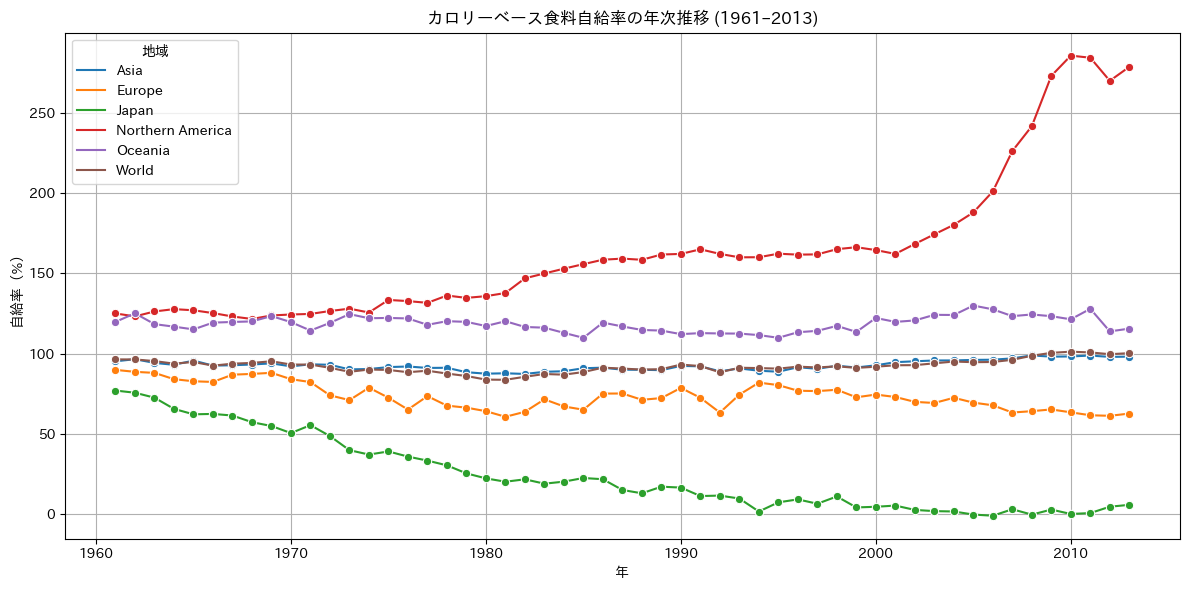

In [7]:
# =======================
# 1. カロリーベース食料自給率
# ======================

# ================================
# 分母の計算: 一人あたりの食料供給量（kcal/日）
# ================================
supply_df = df[df["Element"] == "Food supply (kcal/capita/day)"].copy()
supply_df = supply_df.groupby(["Area", "Year"], as_index=False)["Value"].sum()
supply_df = supply_df.rename(columns={"Value": "kcal_supply"})

# ================================
# 分子の計算: 実質的に食用可能なカロリー量（全体）
# ================================

# 使用する要素（食用以外の利用を控除するため）
elements_needed = [
    "Production",  # 総生産量
    "Feed",        # 飼料用
    "Seed",        # 種子用
    "Losses",      # 損失
    "Other Uses (non-food)",  # 食用以外の用途
    "Processed",   # 加工用
    "Export Quantity",  # 輸出量
    "Stock Variation"   # 在庫変動（増加はプラス）
]

# 品目名の表記統一（例: Rice → Rice (Milled Equivalent)）
df["Item"] = df["Item"].replace({"Rice and products": "Rice (Milled Equivalent)"})

# 品目ごとのカロリー換算係数（kcal/kg）
kcal_factors = {
    "Wheat and products": 3320,
    "Rice (Milled Equivalent)": 3650,
    "Barley and products": 3520,
    "Maize and products": 3700,
    "Potatoes and products": 770,
    "Soybeans": 4460,
    "Vegetables, other": 720,
    "Bovine Meat": 1430,
    "Pigmeat": 1090,
    "Eggs": 1430,
    "Milk - Excluding Butter": 610,
    "Poultry Meat": 1200,
    "Pulses, Other and products": 3520,
    "Sugar (Raw Equivalent)": 3870,
    "Soyabean Oil": 8840,
    "Pelagic Fish": 1420
}

# 対象品目＆要素のデータを抽出
filtered_df = df[
    df["Element"].isin(elements_needed) &
    df["Item"].isin(kcal_factors.keys())
].copy()

# データを要素別に横持ち化（pivot）
pivot_df = filtered_df.pivot_table(
    index=["Area", "Year", "Item"],
    columns="Element",
    values="Value",
    aggfunc="sum"
).fillna(0).reset_index()

# 各品目の食用可能量（1000トン単位）
pivot_df["adjusted_food_1000t"] = (
    pivot_df.get("Production", 0)
    - pivot_df.get("Feed", 0)
    - pivot_df.get("Seed", 0)
    - pivot_df.get("Losses", 0)
    - pivot_df.get("Other Uses (non-food)", 0)
    - pivot_df.get("Processed", 0)
    - pivot_df.get("Export Quantity", 0)
    + pivot_df.get("Stock Variation", 0)
)

# 単位変換：kg → kcalに換算
pivot_df["kg"] = pivot_df["adjusted_food_1000t"] * 1_000_000
pivot_df["kcal"] = pivot_df["kg"] * pivot_df["Item"].map(kcal_factors)

# 地域・年単位で総カロリー合計
kcal_total_df = pivot_df.groupby(["Area", "Year"], as_index=False)["kcal"].sum()

# ================================
# 人口データの取り込み・整形
# ================================
pop_df = df[df["Element"] == "Total Population - Both sexes"].copy()
pop_df = pop_df[["Area", "Year", "Value"]].rename(columns={"Value": "Population"})
pop_df["Population"] = pd.to_numeric(pop_df["Population"], errors="coerce") * 1000  # 単位: 人

# ================================
# 人口1人あたりの供給可能カロリー/日を計算
# ================================
merged_df = pd.merge(kcal_total_df, pop_df, on=["Area", "Year"], how="left")
merged_df["kcal_per_capita_day"] = merged_df["kcal"] / merged_df["Population"] / 365

# ================================
# 食料供給量データと結合 → 自給率を算出
# ================================
final_df = pd.merge(
    merged_df[["Area", "Year", "kcal_per_capita_day"]],
    supply_df[["Area", "Year", "kcal_supply"]],
    on=["Area", "Year"],
    how="inner"
)
final_df["self_sufficiency_rate"] = (final_df["kcal_per_capita_day"] / final_df["kcal_supply"]) * 100

# ================================
# 可視化: 地域別・年次推移のプロット（＋画像保存）
# ================================
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x="Year", y="self_sufficiency_rate", hue="Area", marker="o")
plt.title("カロリーベース食料自給率の年次推移 (1961–2013)")
plt.ylabel("自給率（%）")
plt.xlabel("年")
plt.grid(True)
plt.legend(title="地域")
plt.tight_layout()

# グラフをPNG画像として保存（高解像度、余白込み）
plt.savefig("カロリーベースの食料自給率の年次推移.png", dpi=300, bbox_inches="tight")

plt.show()


# 1. カロリーベースの食料自給率 結果

- 日本は過去40年以上にわたって、カロリーベースの食料自給率が他地域と比べて低い
- 日本のカロリーベースの食料自給率は低下してきた

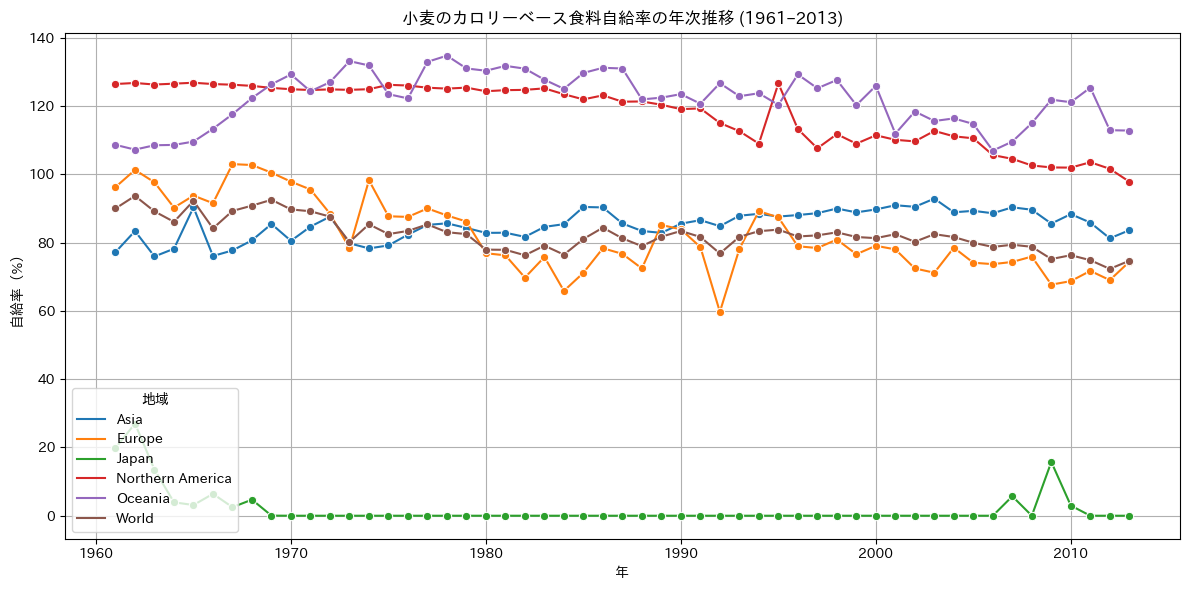

In [8]:
# ============================
# 2. 小麦のカロリーベース食料自給率
# ============================

# ================================
# 小麦のカロリーベース自給率算出（kcal/capita/day単位）
# ================================

# ================================
# カロリー換算係数（kcal/kg）
# ================================
kcal_factors = {
    "Wheat and products": 3320
}

# ================================
# 分母：小麦の一人あたり食料供給量（Food supply）
# ================================
supply_df = df[
    (df["Element"].str.strip().str.title() == "Food Supply (Kcal/Capita/Day)") &
    (df["Item"] == "Wheat and products")
].copy()
supply_df = supply_df.groupby(["Area", "Year"], as_index=False)["Value"].sum()
supply_df = supply_df.rename(columns={"Value": "kcal_supply"})

# ================================
# 分子：小麦の実質食用可能カロリー（非食用用途等を控除）
# ================================
elements_needed = [
    "Production", "Feed", "Seed", "Losses",
    "Other Uses (non-food)", "Processed",
    "Export Quantity", "Stock Variation"
]

# 小麦に限定して必要要素を抽出
filtered_df = df[
    (df["Item"] == "Wheat and products") &
    (df["Element"].isin(elements_needed))
].copy()

# 要素ごとにピボット（横持ち化）
pivot_df = filtered_df.pivot_table(
    index=["Area", "Year"],
    columns="Element",
    values="Value",
    aggfunc="sum"
).fillna(0).reset_index()

# 実質食用量（1000トン）を計算
pivot_df["adjusted_food_1000t"] = (
    pivot_df.get("Production", 0)
    - pivot_df.get("Feed", 0)
    - pivot_df.get("Seed", 0)
    - pivot_df.get("Losses", 0)
    - pivot_df.get("Other Uses (non-food)", 0)
    - pivot_df.get("Processed", 0)
    - pivot_df.get("Export Quantity", 0)
    + pivot_df.get("Stock Variation", 0)
)

# マイナス値は0にクリップ（現実的でないため）
pivot_df["adjusted_food_1000t"] = pivot_df["adjusted_food_1000t"].clip(lower=0)

# kcalへ換算
pivot_df["kcal"] = pivot_df["adjusted_food_1000t"] * 1_000_000 * kcal_factors["Wheat and products"]
kcal_total_df = pivot_df[["Area", "Year", "kcal"]]

# ================================
# 人口データの整形（1000人 → 人）
# ================================
pop_df = df[df["Element"] == "Total Population - Both sexes"].copy()
pop_df = pop_df[["Area", "Year", "Value"]].rename(columns={"Value": "Population"})
pop_df["Population"] = pd.to_numeric(pop_df["Population"], errors="coerce") * 1000

# ================================
# 人口1人あたりの小麦由来kcal/日を計算
# ================================
merged_df = pd.merge(kcal_total_df, pop_df, on=["Area", "Year"], how="left")
merged_df = merged_df[merged_df["Population"] > 0]
merged_df["kcal_per_capita_day"] = merged_df["kcal"] / merged_df["Population"] / 365

# ================================
# 小麦のカロリーベース自給率を算出
# ================================
final_df = pd.merge(
    merged_df[["Area", "Year", "kcal_per_capita_day"]],
    supply_df[["Area", "Year", "kcal_supply"]],
    on=["Area", "Year"],
    how="inner"
)
final_df["self_sufficiency_rate"] = (
    final_df["kcal_per_capita_day"] / final_df["kcal_supply"]
) * 100

# ================================
# 可視化 ＋ PNG形式で保存
# ================================
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=final_df,
    x="Year",
    y="self_sufficiency_rate",
    hue="Area",
    marker="o"
)
plt.title("小麦のカロリーベース食料自給率の年次推移 (1961–2013)")
plt.ylabel("自給率（%）")
plt.xlabel("年")
plt.grid(True)
plt.legend(title="地域")
plt.tight_layout()

# グラフ画像として保存（高解像度）
plt.savefig("小麦のカロリーベース食料自給率の年次推移.png", dpi=300, bbox_inches="tight")

plt.show()


# 2. 小麦のカロリーベース食料自給率 結果

- 日本の小麦のカロリーベース食料自給率は他地域と比べて低い
- 北米・オセアニアなど主要生産地域では、高い自給率を維持(100%超)